In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

def reset_timestamp(df):
    df['timestamp'] = df['timestamp'] - df['timestamp'][0]
    return df

def process_line(line):
    timestamp = line.split(' ')[1]
    content = line.split('  : ')[1]
#     print(content)
    pairs = content.split(',')
#     print(pairs)
    d = {}
    cpugpu = re.search("CPU4/GPU=\d+/\d+,\d+/\d+", content).group()
    cpugpu = cpugpu.split('=')[1]
    cpugpu = cpugpu.split('/')
    d['CPU Level'] = int(cpugpu[0])
    d['GPU Level'] = int(cpugpu[1].split(',')[0])
    d['CPU Frequency (MHz)'] = int(cpugpu[1].split(',')[1])
    d['GPU Frequency (MHz)'] = int(cpugpu[2])
    for x in pairs:
        tmp = x.split('=')
        if tmp[0] == 'CPU4/GPU' or len(tmp) < 2:
            continue
        if tmp[0] == 'FPS':
            d[tmp[0]] = int(tmp[1].split('/')[0])
        elif tmp[0] == 'Free':
            d[tmp[0]] = int(tmp[1][:-2])
        else:
            d[tmp[0]] = tmp[1].strip()

    d["timestamp"] = timestamp

    return pd.DataFrame(d, index=[0])

def add_to_dataframe(df, timestamp, key, value):
    if key not in df.columns:
        df[key] = np.nan
    df.loc[timestamp, key] = value
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        if len(line) < 300:
            continue
        new_d = process_line(line)
        df = pd.concat([df, new_d])

    folder = file_path.split('/')[1:]
    print(folder)

    df['experiment'] = folder[0]
    df['device'] = folder[1]
    df['repetition'] = "record" if "record" in  folder[4] else "replay" 

    df.to_csv(f'.{file_path.strip(".log")}.csv', index=False)

    return df

def process_logcat():
    df_aggregated = pd.DataFrame()
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if(name == 'logcat_VrApi.log') and ("clumsy-bandwidth" in os.path.join(root, name)):
                # print(name)
                print(os.path.join(root, name))

                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))]) 

    return df_aggregated


In [30]:
import warnings
warnings.filterwarnings("ignore")

df = process_logcat()
df

./clumsy-bandwidth-50Mbps/Quest-2/BeatSaber/PopStars-Medium/record1/logcat_VrApi.log
['clumsy-bandwidth-50Mbps', 'Quest-2', 'BeatSaber', 'PopStars-Medium', 'record1', 'logcat_VrApi.log']
./clumsy-bandwidth-50Mbps/Quest-2/BeatSaber/PopStars-Medium/replay1.0/logcat_VrApi.log
['clumsy-bandwidth-50Mbps', 'Quest-2', 'BeatSaber', 'PopStars-Medium', 'replay1.0', 'logcat_VrApi.log']
./clumsy-bandwidth-50Mbps/Quest-2/BeatSaber/PopStars-Medium/replay1.1/logcat_VrApi.log
['clumsy-bandwidth-50Mbps', 'Quest-2', 'BeatSaber', 'PopStars-Medium', 'replay1.1', 'logcat_VrApi.log']
./clumsy-bandwidth-50Mbps/Quest-2/BeatSaber/PopStars-Medium/replay1.2/logcat_VrApi.log
['clumsy-bandwidth-50Mbps', 'Quest-2', 'BeatSaber', 'PopStars-Medium', 'replay1.2', 'logcat_VrApi.log']
./clumsy-bandwidth-50Mbps/Quest-Pro/BeatSaber/PopStars-Medium/record1/logcat_VrApi.log
['clumsy-bandwidth-50Mbps', 'Quest-Pro', 'BeatSaber', 'PopStars-Medium', 'record1', 'logcat_VrApi.log']
./clumsy-bandwidth-50Mbps/Quest-Pro/BeatSaber/Pop

,CPU Level,GPU Level,CPU Frequency (MHz),GPU Frequency (MHz),FPS,Prd,Tear,Early,Stale,Stale2/5/10/max,...,CFL,ICFLp95,LD,SF,LP,DVFS,timestamp,experiment,device,repetition
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,15.40/21.11,19.02,0,1.21,0,0,16:34:55.033,clumsy-bandwidth-50Mbps,Quest-2,record
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,15.17/21.19,18.97,0,1.21,0,0,16:34:56.034,clumsy-bandwidth-50Mbps,Quest-2,record
0,5,4,1478,525,72,0ms,0,0,0,0/0/0/0,...,14.89/21.20,18.47,0,1.21,0,0,16:34:57.040,clumsy-bandwidth-50Mbps,Quest-2,record
0,5,4,1478,525,73,0ms,0,0,1,0/0/0/1,...,14.85/20.50,18.33,0,1.21,0,0,16:34:58.034,clumsy-bandwidth-50Mbps,Quest-2,record
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,14.91/20.56,18.47,0,1.21,0,0,16:34:59.034,clumsy-bandwidth-50Mbps,Quest-2,record
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,4,1382,525,48,0ms,0,0,32,0/0/0/0,...,19.03/24.28,22.45,1,1.21,0,0,16:53:48.117,clumsy-bandwidth-30Mbps,Quest-Pro,replay
0,3,4,1382,525,72,0ms,0,0,7,0/0/1/39,...,20.14/25.76,23.76,1,1.21,0,0,16:53:49.117,clumsy-bandwidth-30Mbps,Quest-Pro,replay
0,3,4,1382,525,66,0ms,0,0,3,1/0/0/2,...,19.54/24.74,23.03,1,1.21,0,0,16:53:50.117,clumsy-bandwidth-30Mbps,Quest-Pro,replay
0,3,4,1382,525,71,0ms,0,0,38,0/0/1/39,...,20.12/24.52,23.06,1,1.21,0,0,16:53:51.117,clumsy-bandwidth-30Mbps,Quest-Pro,replay


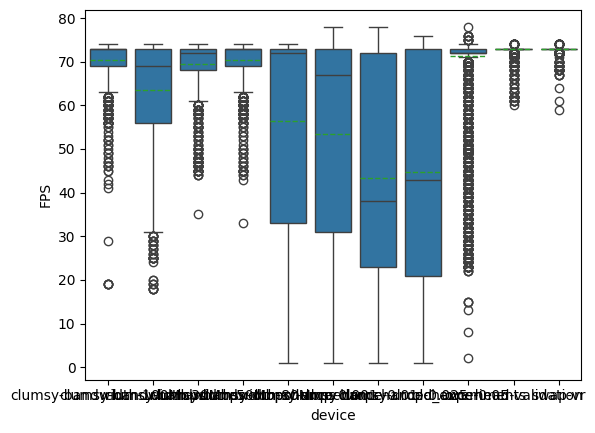

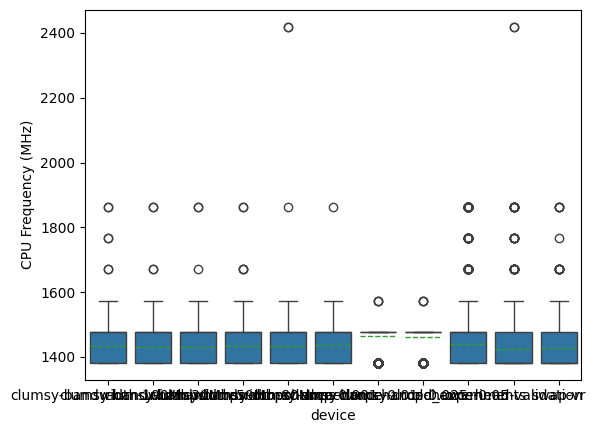

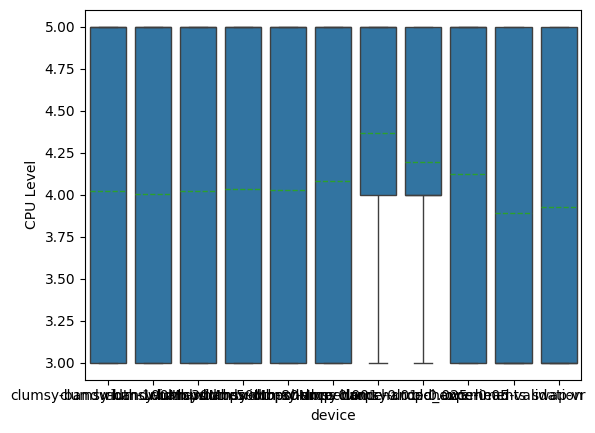

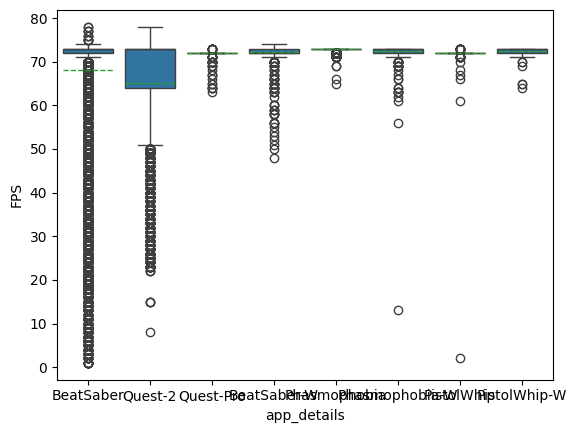

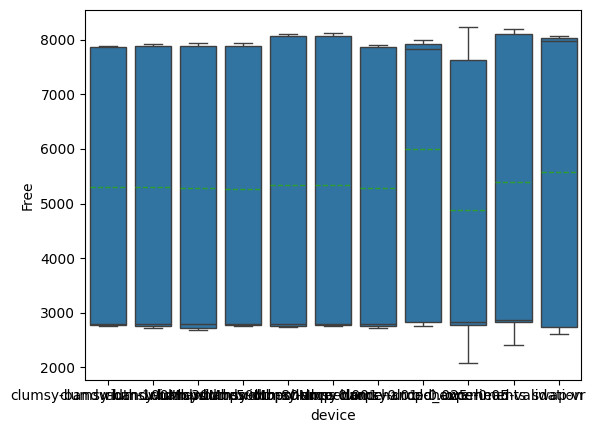

In [6]:
df[["FPS", "CPU Level", "CPU Frequency (MHz)", "Free"]] = df[["FPS", "CPU Level", "CPU Frequency (MHz)", "Free"]].apply(pd.to_numeric)

sns.boxplot(data=df, x='device', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='CPU Frequency (MHz)', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='CPU Level', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='app_details', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='Free', showmeans=True, meanline=True)
plt.show()


In [7]:
import matplotlib.pyplot as plt

def simplify_runs(row) :
    if "baseline" in row:
        return 'baseline'
    elif "replay" in row:
        return 'replay'
    else :
        return 'record'


print(temp.columns)

temp = df[df["device"] == 'overhead-validation']

temp['type'] = temp['type'].apply(simplify_runs)

pro = temp[temp['app'] == 'Quest-Pro']
two = temp[temp['app'] == 'Quest-2']

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))

sns.set_theme(palette='deep')
sns.violinplot(ax=axes[0], data=pro, x='type', y='FPS')
sns.violinplot(ax=axes[1], data=two, x='type', y='FPS')

axes[0].set(ylabel='FPS', xlabel='Quest-Pro')
axes[1].set(ylabel='FPS', xlabel='Quest-2')



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\radua\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\radua\AppData\Local\Temp\ipykernel_14660\1187724177.py", line 12, in <module>
    print(temp.columns)
          ^^^^
NameError: name 'temp' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\radua\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\radua\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\radua\AppData\Roaming\Python\Pyth

# Quest Pro replay energy difference

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 }
# custom_params = {}

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)
sns.set_palette("colorblind")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

path = './overhead-validation/Quest-Pro/BeatSaber/PopStars-Medium/'

# def reset_timestamp(df):
#     df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M:%S.%f")
#     df['timestamp'] = df['timestamp'] - df['timestamp'][0]
#     return df

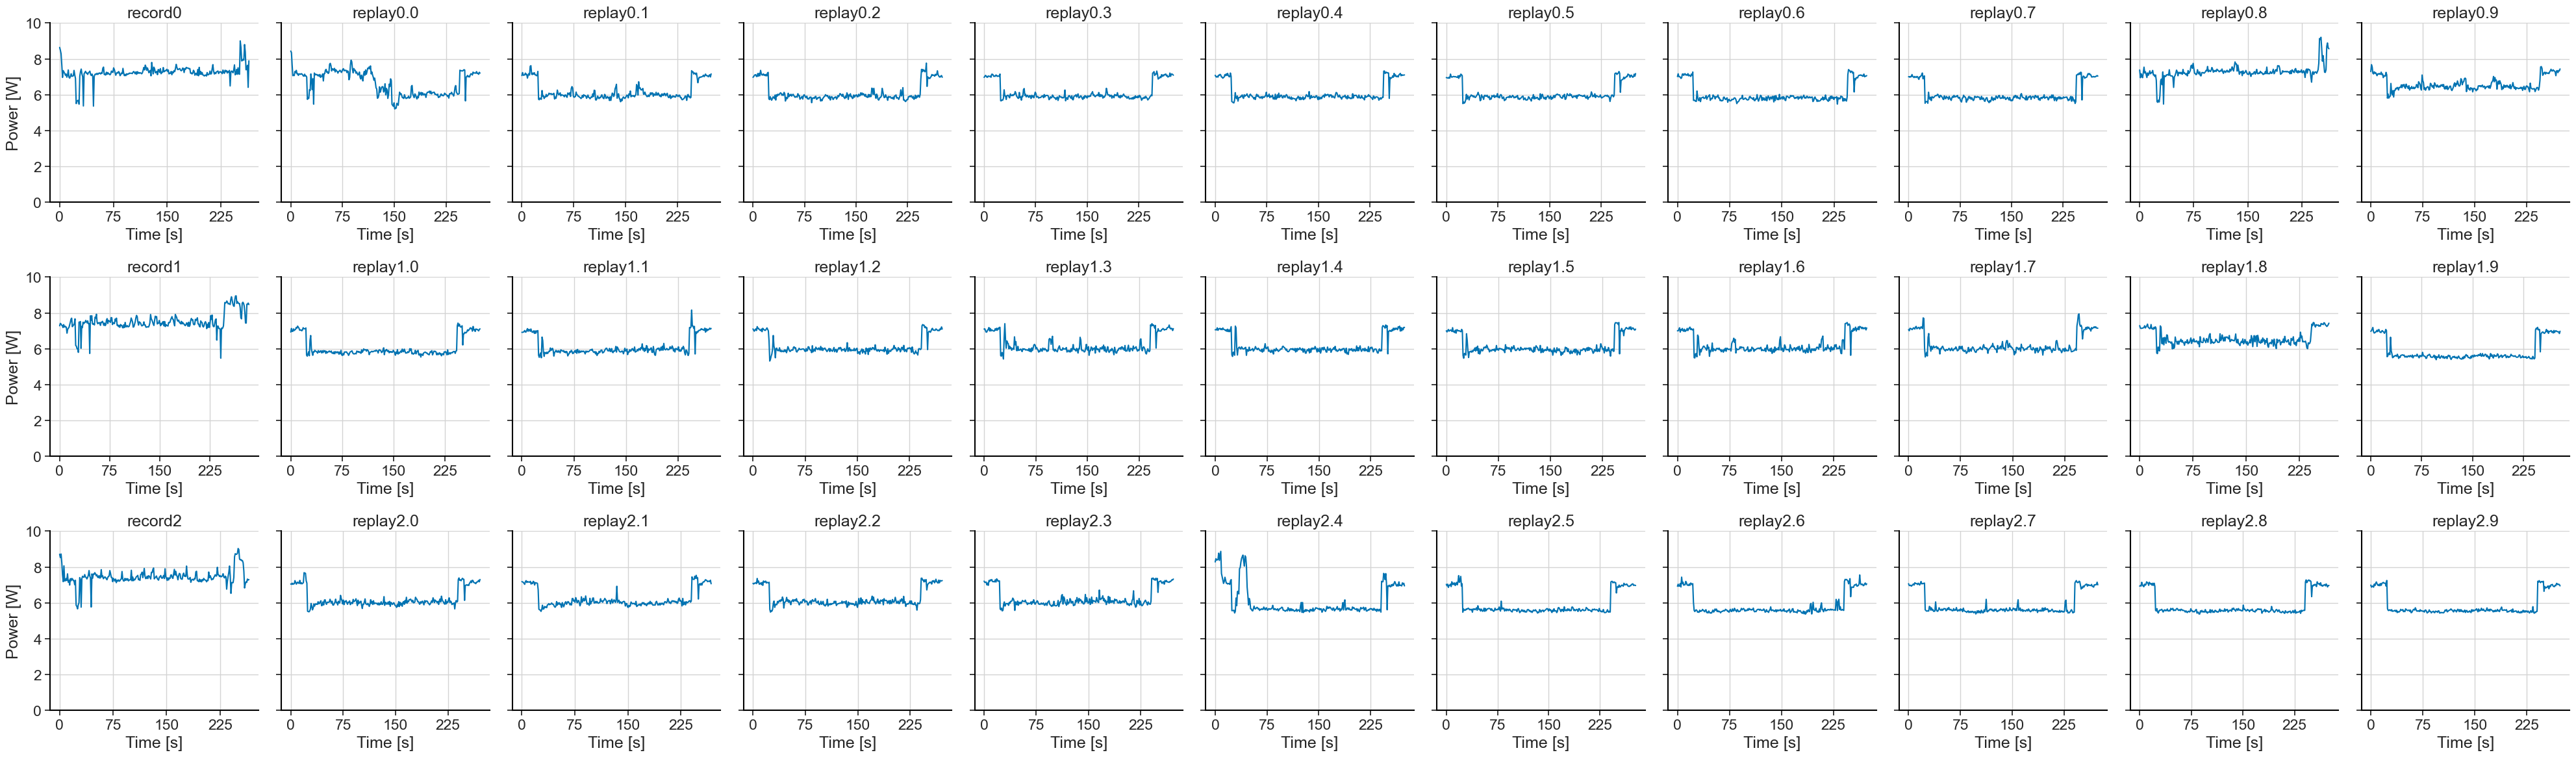

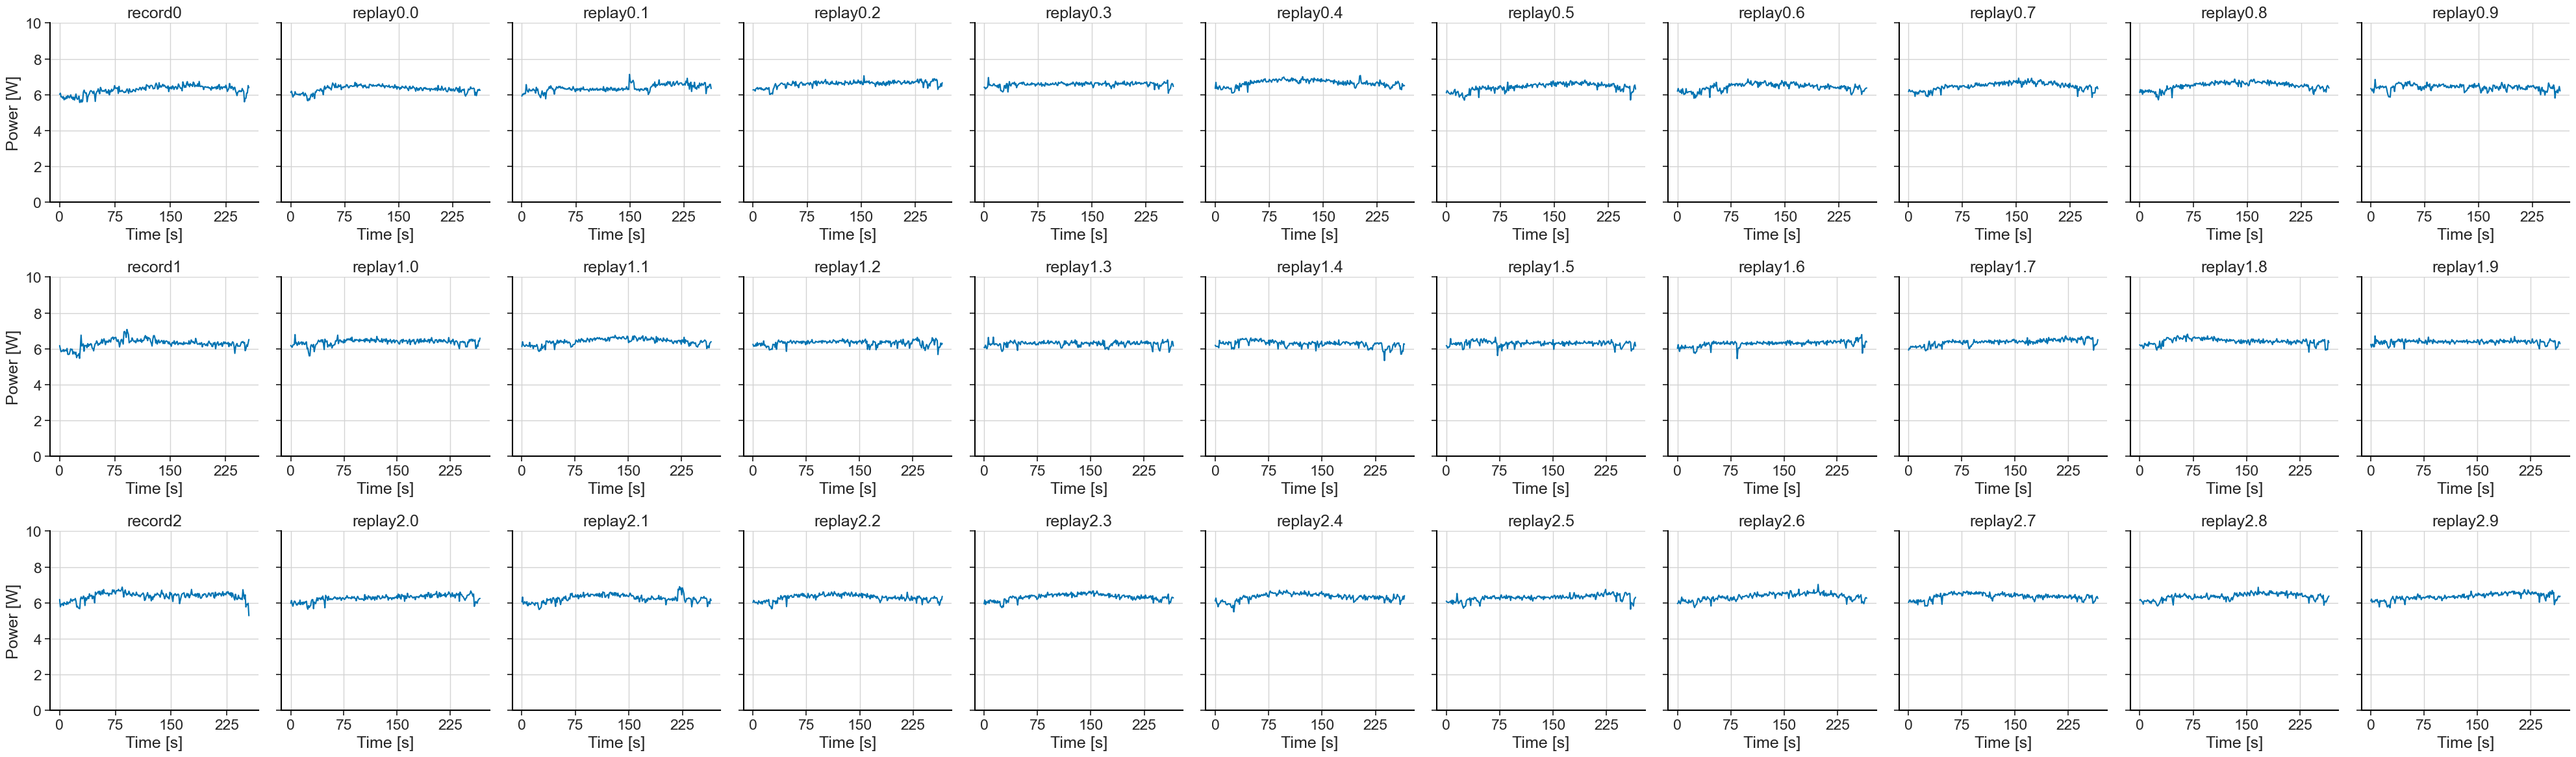

In [23]:
def power_consumption_grapharray_validation(path, outname):
    fig, ax = plt.subplots(3, 11, figsize=(40, 12), sharey=True)
    for record in range(3):
        df = pd.read_csv(f'{path}record{record}/battery_manager.csv')
        # fig.suptitle('record' + str(record))
        # df = reset_timestamp(df)
        sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[record][0])
        ax[record][0].set_title('record' + str(record))
        ax[record][0].set_xlabel('Time [s]')
        ax[record][0].set_ylabel('Power [W]')
        ax[record][0].set_xticks(np.arange(0, 300, 75))
        ax[record][0].set_ylim(0, 10)
        ax[record][0].set_yticks(np.arange(0, 11, 2))


        for replay in range(10):
            df = pd.read_csv(f'{path}replay{record}.{replay}/battery_manager.csv')
            # df = reset_timestamp(df)
            sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[record][replay + 1])
            ax[record][replay + 1].set_title(f'replay{record}.{replay}')
            ax[record][replay + 1].set_xlabel('Time [s]')
            ax[record][replay + 1].set_xticks(np.arange(0, 300, 75))

    plt.tight_layout()
    plt.savefig(f'./figures/replay_investigation/{outname}_power.pdf', format='pdf')
    plt.show()

power_consumption_grapharray_validation('./overhead-validation/Quest-Pro/BeatSaber/PopStars-Medium/', 'Quest-Pro')
power_consumption_grapharray_validation('./overhead-validation/Quest-2/BeatSaber/PopStars-Medium/', 'Quest-2')

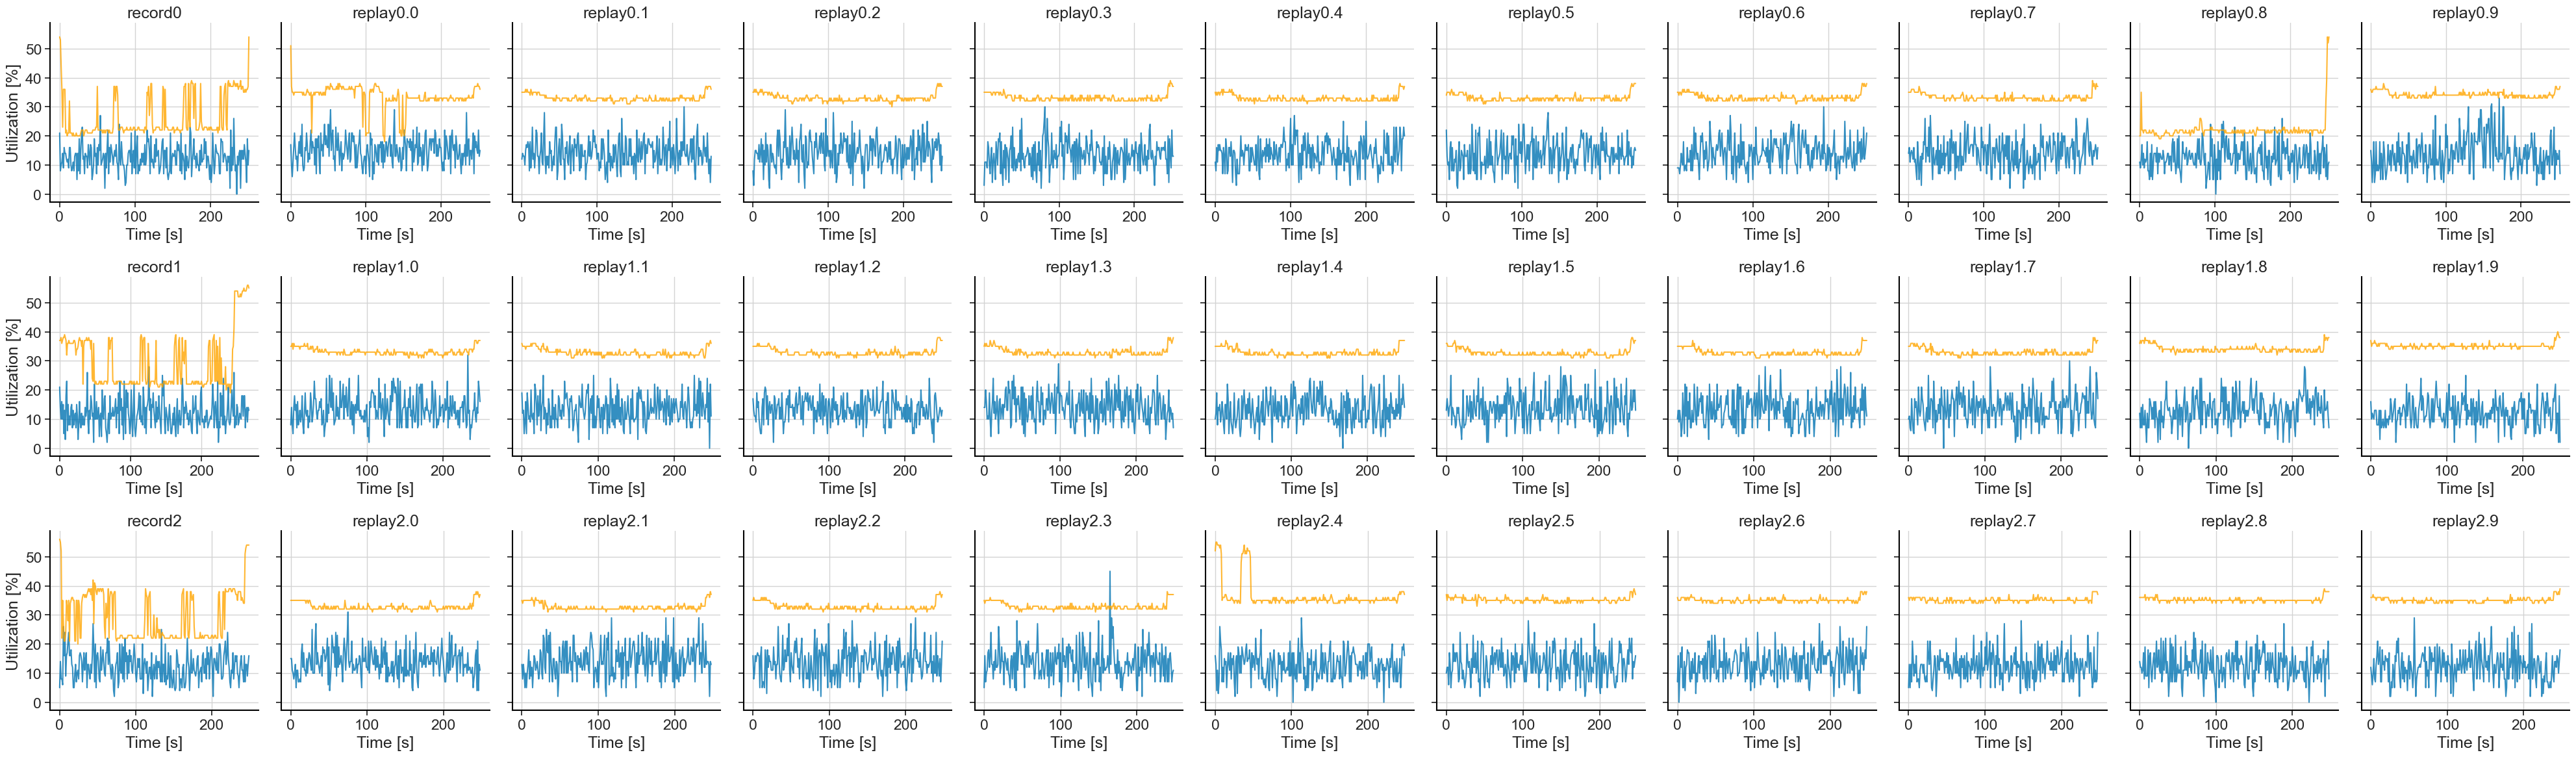

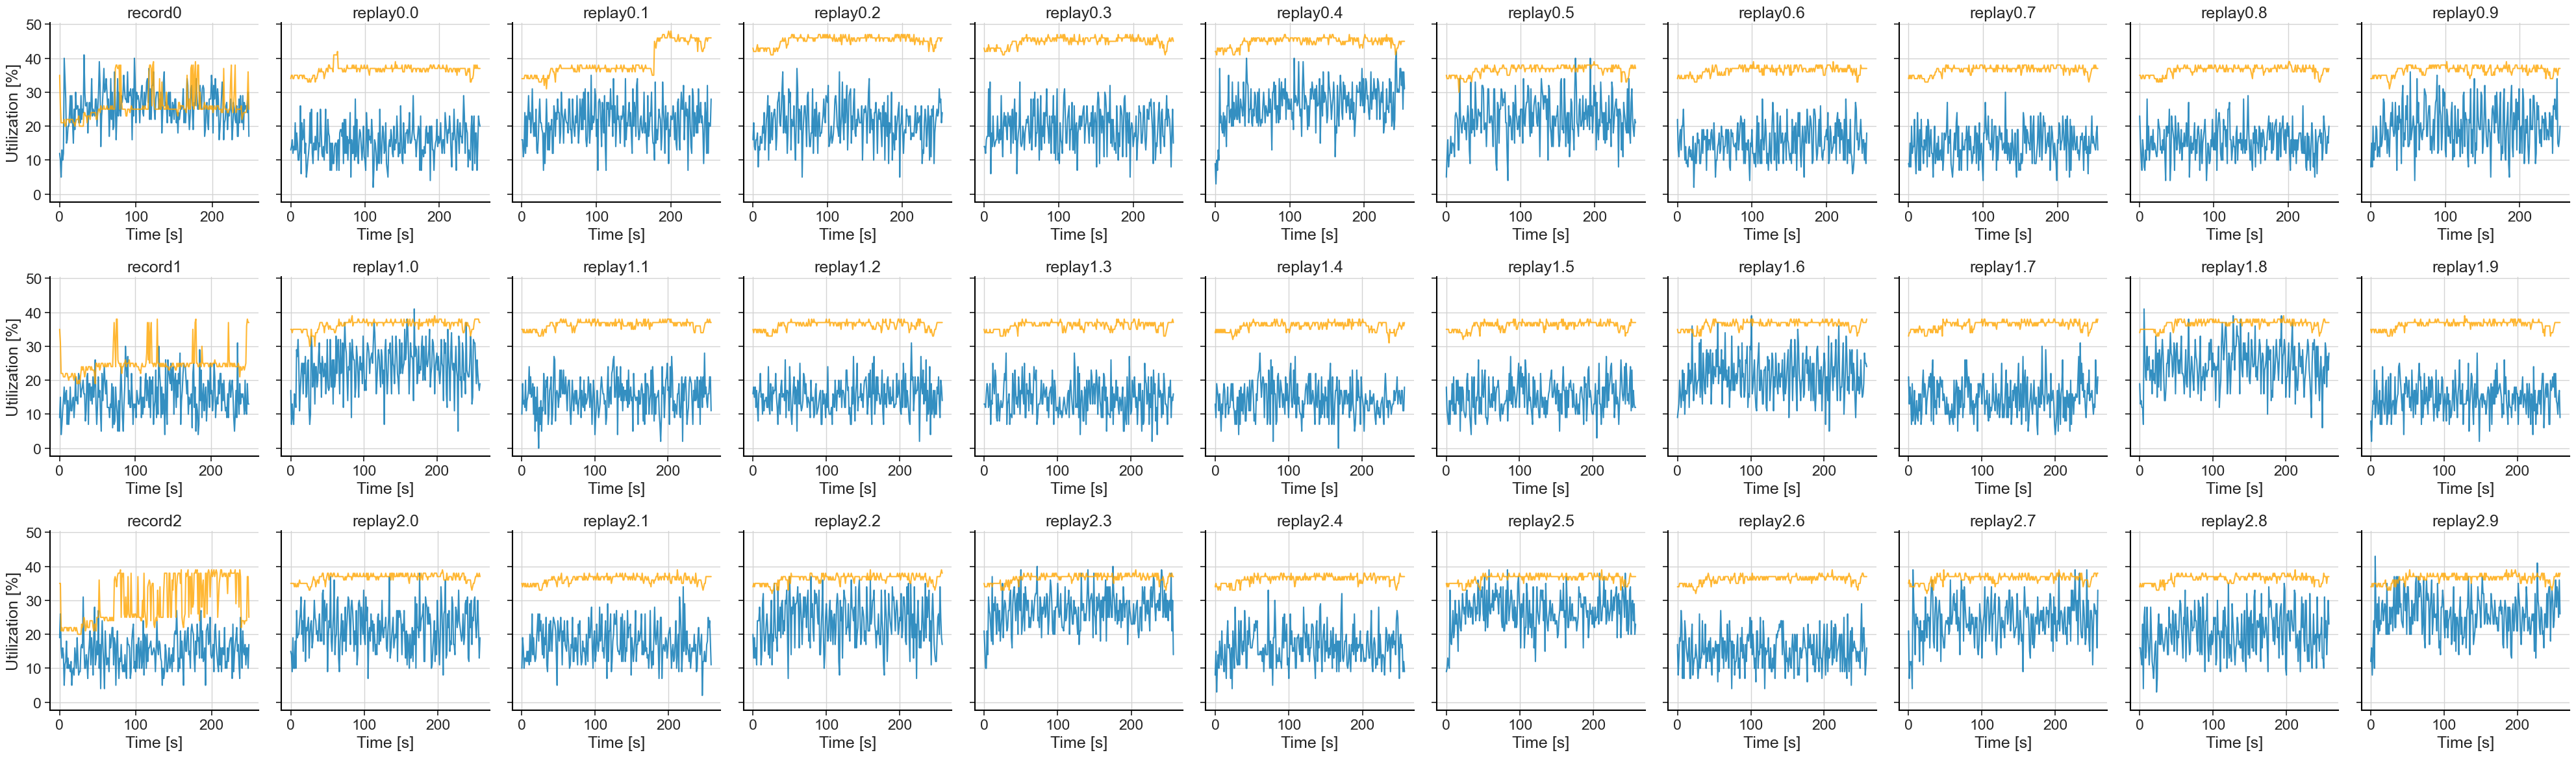

In [ ]:
def reset_timestamp(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M:%S.%f")
  df['timestamp'] = df['timestamp'] - df['timestamp'][0]
  # convert to milliseconds
  df['timestamp'] = df['timestamp'].dt.total_seconds()
  return df

def cpu_gpu_grapharray_validation(path, outname):
    fig, ax = plt.subplots(3, 11, figsize=(40, 12), sharey=True)
    for record in range(3):
        df = pd.read_csv(f'{path}record{record}/logcat_VrApi.csv')
        df['CPU%'] = df['CPU%'].apply(lambda x: float(x.split('(')[0])*100)
        df['GPU%'] = df['GPU%'].apply(lambda x: float(x)*100)
        # print(df['CPU%'].dtype, df['CPU%'].head(1))
        # reset timestamp to 0
        df = reset_timestamp(df)

        sns.lineplot(data=df, x='timestamp', y='CPU%', label="CPU", ax=ax[record][0], alpha=0.8)
        sns.lineplot(data=df, x='timestamp', y='GPU%', label="GPU", ax=ax[record][0], color="orange", alpha=0.8)
        
        # df['Temp'] = df['Temp'].apply(lambda x: float(x.split('C/')[record][0]))
        # twin = ax[record][0].twinx()
        # sns.lineplot(data=df, x='timestamp', y='Temp', label="Temp", ax=twin, color='r', alpha=0.8)

        ax[record][0].set_yticks(np.arange(0, 101, 10)) 
        ax[record][0].set_ylabel('Utilization [%]')
        ax[record][0].set_xlabel('Time [s]')
        ax[record][0].set_title('record' + str(record))
        ax[record][0].legend().remove()

        for replay in range(10):
            df = pd.read_csv(f'{path}replay{record}.{replay}/logcat_VrApi.csv')
            df['CPU%'] = df['CPU%'].apply(lambda x: float(x.split('(')[0])*100)
            df['GPU%'] = df['GPU%'].apply(lambda x: float(x)*100)
            df = reset_timestamp(df)

            sns.lineplot(data=df, x='timestamp', y='CPU%', label="CPU", ax=ax[record][replay + 1], alpha=0.8)
            sns.lineplot(data=df, x='timestamp', y='GPU%', label="GPU", ax=ax[record][replay + 1], color="orange", alpha=0.8)

            # df['Temp'] = df['Temp'].apply(lambda x: float(x.split('C/')[0]))
            # twin = ax[record][replay + 1].twinx()
            # sns.lineplot(data=df, x='timestamp', y='Temp', label="Temp", ax=twin, color='r', alpha=0.8)

            ax[record][replay + 1].set_title(f'replay{record}.{replay}')
            ax[record][replay + 1].set_xlabel('Time [s]')
            ax[record][replay + 1].legend().remove()

    plt.tight_layout()
    plt.savefig(f'./figures/replay_investigation/{outname}_cpu_gpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()

cpu_gpu_grapharray_validation('./overhead-validation/Quest-Pro/BeatSaber/PopStars-Medium/', 'Quest-Pro')
cpu_gpu_grapharray_validation('./overhead-validation/Quest-2/BeatSaber/PopStars-Medium/', 'Quest-2')

## Swap VR

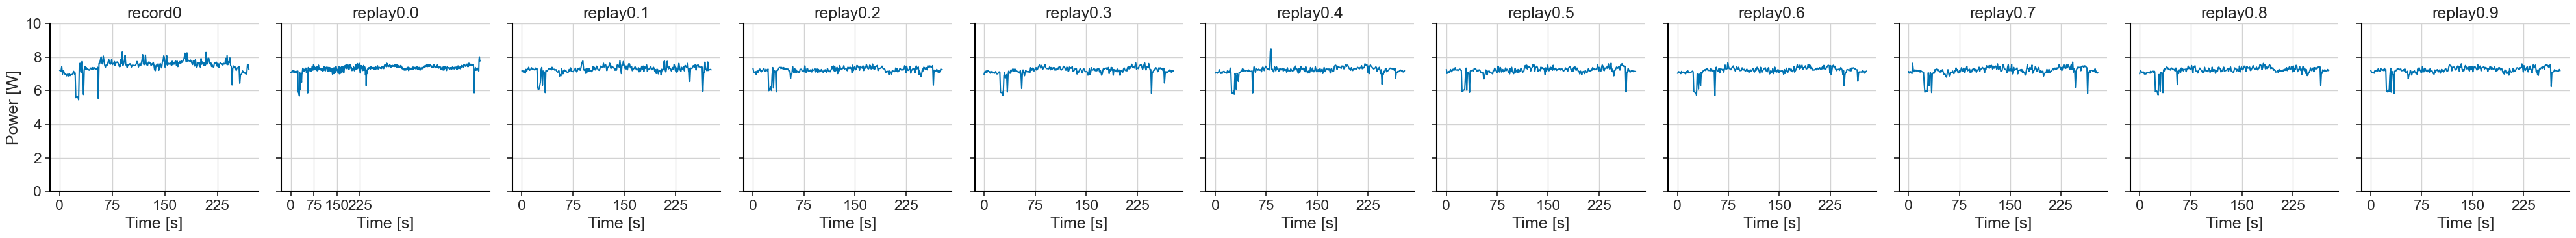

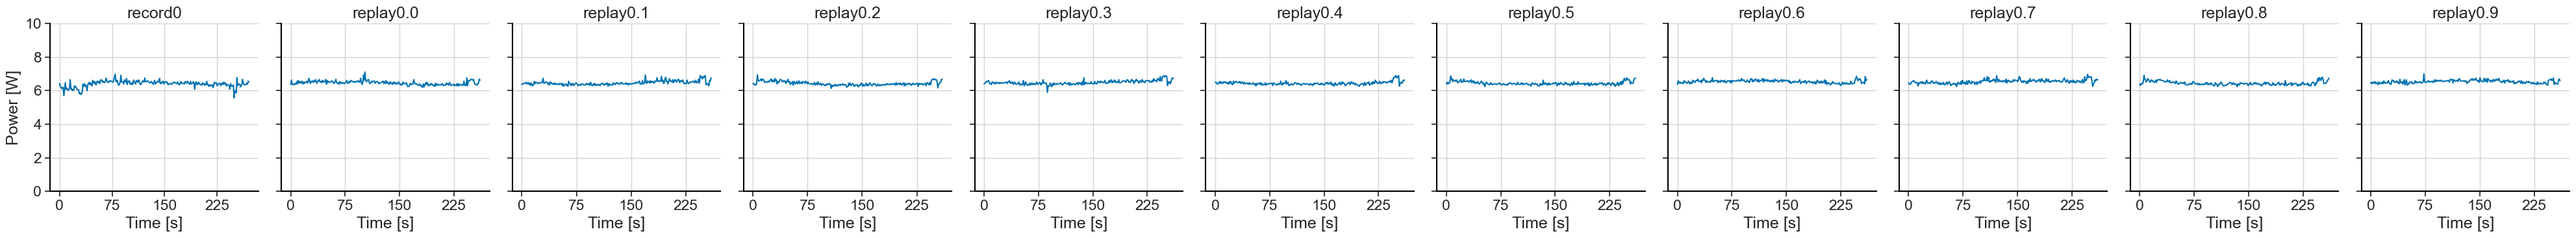

In [22]:
def power_consumption_grapharray_swap(path, outname):
    fig, ax = plt.subplots(1, 11, figsize=(40, 4), sharey=True)

    df = pd.read_csv(f'{path}record0/battery_manager.csv')
    # fig.suptitle('record' + str(record))
    # df = reset_timestamp(df)
    sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[0])
    ax[0].set_title('record' + '0')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Power [W]')
    ax[0].set_xticks(np.arange(0, 300, 75))
    ax[0].set_ylim(0, 10)
    ax[0].set_yticks(np.arange(0, 11, 2))


    for replay in range(10):
        df = pd.read_csv(f'{path}replay0.{replay}/battery_manager.csv')
        # df = reset_timestamp(df)
        sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[replay + 1])
        ax[replay + 1].set_title(f'replay0.{replay}')
        ax[replay + 1].set_xlabel('Time [s]')
        ax[replay + 1].set_xticks(np.arange(0, 300, 75))

    plt.tight_layout()
    # plt.savefig(f'./figures/replay_investigation/{outname}_power.pdf', format='pdf')
    plt.show()

power_consumption_grapharray_swap('./swap-vr/Quest-Pro/BeatSaber/PopStars-Medium/', 'Quest-Pro')
power_consumption_grapharray_swap('./swap-vr/Quest-2/BeatSaber/PopStars-Medium/', 'Quest-2')